# Bayesian uncertainty quantification Jupyter notebook

In [38]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy
import pandas as pd

#Some pretty colors I like
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [54]:
# reading the oslo data for 300 bin (6,9)

df=pd.read_csv("gsf_300(6,9).csv")

# convert to python arrays
energy=df["energy"].values # as numpy array
gsf=df["gsf"].values 
error=df["errors"].values



[4.4642469e-08 2.1417449e-08 3.0064271e-08 1.4119474e-08 1.4170475e-08
 1.6503236e-08 1.5904115e-08 2.8677555e-08 1.2044566e-08 1.0822393e-08
 1.2346848e-08 1.9457129e-08 3.3177496e-08 4.3603556e-08 4.0886103e-08
 3.6623238e-08 3.1313128e-08 1.1291703e-07]
[1.2440548e-08 8.8947711e-09 8.7066931e-09 5.7278280e-09 4.9300573e-09
 6.0577459e-09 5.1955995e-09 8.7863770e-09 4.5278847e-09 4.6125388e-09
 6.3965029e-09 9.4214316e-09 1.4354725e-08 2.1856451e-08 1.9872710e-08
 1.9722471e-08 2.6522793e-08 6.4336028e-08]


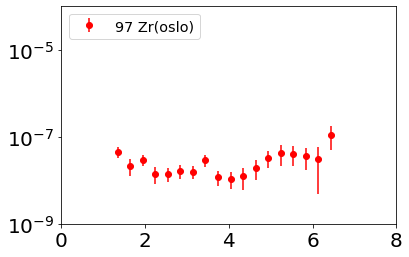

In [40]:
# Plot the oslo data with error bars

fig = plt.figure()


plt.errorbar(energy, gsf,yerr=error,fmt="o", color="r",ecolor='r',label='97 Zr(oslo)')

plt.yscale("log")

plt.xlim(0, 8)
plt.ylim(10**(-9),10**(-4))

plt.legend(loc ='upper left',fontsize="x-large")
plt.show()

<font size="5">
The model we will use to fit to this data set is:
    
    

strength 8 , strength M1 2

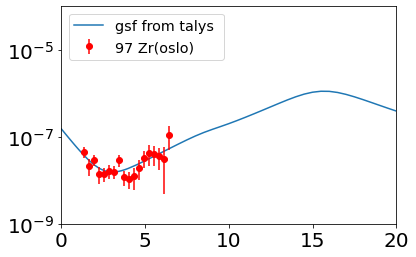

In [41]:
# strength 8 model from talys obtained

df2=pd.read_csv("gsf_300(6,9)_talys.csv")

energy_t=df2["energy"].values
gsf_t=df2["gsf"].values



fig = plt.figure()


plt.plot(energy_t,gsf_t,label='gsf from talys ')
plt.errorbar(energy, gsf,yerr=error,fmt="o", color="r",ecolor='r',label='97 Zr(oslo)')

plt.yscale("log")

plt.xlim(0, 20)
plt.ylim(10**(-9),10**(-4))

plt.legend(loc ='upper left',fontsize="x-large")
plt.show()


<font size="5">
Linear interpolation

In [42]:
#linear interpolation for the talys values on energy/x in the oslo data
# needed for the likelihood function


intp_gsf = np.interp(energy, energy_t, gsf_t)



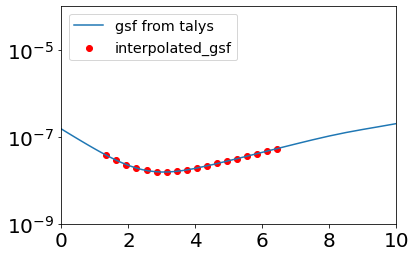

18


In [43]:
#verification whether the interpolation did its job!!! interpolated data vs model

fig = plt.figure()


plt.plot(energy_t,gsf_t,label='gsf from talys ')

plt.scatter(energy,intp_gsf,label='interpolated_gsf',color='r')

plt.yscale("log")

plt.xlim(0, 10)
plt.ylim(10**(-9),10**(-4))

plt.legend(loc ='upper left',fontsize="x-large")
plt.show()


print(intp_gsf.size)

Bayesian starts here

In [ ]:
def model_all(params):
    return params[0]+params[1]*gsf_t


In [45]:
def model_8(j,params):
    return params[0]+params[1]*intp_gsf[j]


In [46]:

# Define the likelihood function for given errors sigma
def likelihood(params,arguments):
#Assumed format for data=[xvals,yvals]
    data, model, sigmas = arguments
    likelihood_log_val=0

    for i in range(len(data[0])):
        likelihood_log_val=likelihood_log_val-1/2*((data[1][i] - model_8(i,params)) / sigmas[i])**2\
        -np.log(2*np.pi*sigmas[i]**2)/2
      
        
    return np.exp(likelihood_log_val)

# Define the prior function
def prior_model_A(params_vals,arguments):
    params0,params0_Cov_Inv_matrix=arguments
    mu=np.array(params_vals)-np.array(params0)
    params_size=len(params_vals)
    return (2*np.pi)**(-params_size/2)*np.sqrt(np.linalg.det(params0_Cov_Inv_matrix))*np.exp(-np.dot(mu,np.dot(params0_Cov_Inv_matrix,mu))/2)



In [174]:
# Define the Metropolis algorithm
def metropolis(data,sigma, prior,prior_arguments, likelihood,model,\
               num_iterations, step_size):
#     step_size should be a list the size of the parameters of the model
    likelihood_arguments=[data, model, sigma]
    initial_parameters=prior_arguments[0]
    #thermalizing
    burn_samples=1000
    # Set the initial state of the chain
    params_current=initial_parameters
    params_list=[]
    posterior_list=[]
    
    acceptance_times=0
    
    cov_step_size=np.diag(step_size)**2
    
    posterior_current=(likelihood(params_current,likelihood_arguments))*(prior(params_current,\
                                                                               prior_arguments))
    
    # Run the Metropolis-Hastings algorithm for burning
    for i in range(burn_samples):
        # Propose a new state for the chain
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*(prior(params_proposed,\
                                                                               prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed


    for i in range(num_iterations):
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*\
        (prior(params_proposed,prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed
            acceptance_times=acceptance_times+1

        # Store the current state
        params_list.append(params_current)
        posterior_list.append(posterior_current)
        
    
    #Rule of thumb acceptance is around 50%. 
    #You could plot the accuracy of the estimations as a function of this rate, that would be interesting to see. 
    print(acceptance_times/num_iterations*100,"%")
    
    return(np.array(params_list),np.array(posterior_list),\
           acceptance_times/num_iterations*100)



In [327]:
np.random.seed(142857)

#Setting up the prior
#prior_arguments_A=[[0,0.9],np.linalg.inv(np.diag([2**2,2**2]))]

prior_arguments_A=[[0,1],np.array([[1e-8, 0], [0, 0.3397]])]

#Doing the Metropolis sampling for 100000 values
results_A=metropolis([energy,gsf],error, prior_model_A,\
                         prior_arguments_A, likelihood,model_8,100000, [5.3e-9,0.005])
all_chains =results_A[0]

print(all_chains)

37.164 %
[[-3.18078018e-09  9.92656976e-01]
 [-3.18078018e-09  9.92656976e-01]
 [-3.18078018e-09  9.92656976e-01]
 ...
 [-3.59372559e-09  1.01255540e+00]
 [-2.16106553e-09  1.01248663e+00]
 [-2.16106553e-09  1.01248663e+00]]


Lets plot the parameters we visited from the Metropolis algorithm using the corner package in python

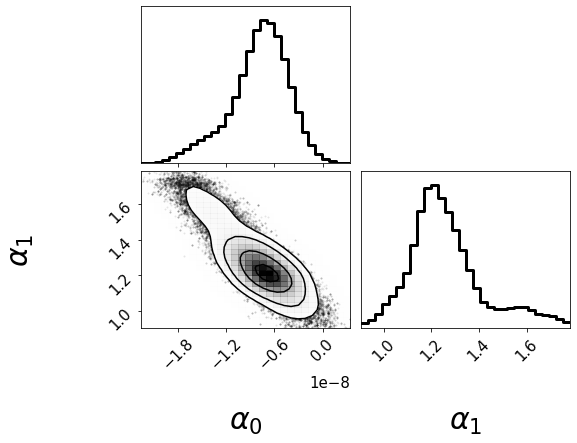

In [328]:

figure = corner.corner(all_chains,
    labels=[r'$\alpha_0$',r'$\alpha_1$'],
    labelpad=0.2,
                       bins=30,
    label_kwargs={"fontsize":30},
                      hist_kwargs= {"linewidth":3},
    quantiles=None
#                        ,truths=[0,1], truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 8
height = 6
figure.set_size_inches(width, height)
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)



In [330]:
#Taking 10000 samples from the visited posterior to estimate the percentiles in the model predictions

rng = np.random.default_rng()
alpha_rand = rng.choice(all_chains,(10000),replace=False)

print(alpha_rand)

[[-8.85275338e-09  1.26692468e+00]
 [-5.55238026e-09  1.15925305e+00]
 [-7.56975340e-09  1.31994855e+00]
 ...
 [-4.18648772e-09  1.18750592e+00]
 [-4.65035681e-09  1.20791402e+00]
 [-5.81558851e-09  1.15998156e+00]]


Lets make a plot of the predictions of our calibrated model

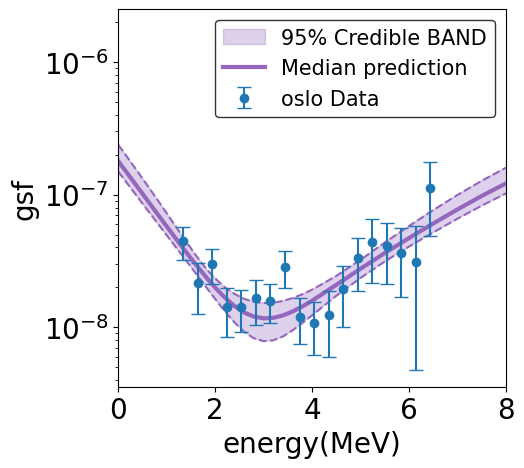

In [334]:
np.random.seed(142857)


func_rand=[model_all(alpha) for alpha in alpha_rand]

fig, ax = plt.subplots(figsize=(5,5),dpi=100)
median = np.percentile(func_rand, 50, axis = 0)
upper = (np.percentile(func_rand, 97.5, axis = 0))

prediction_color_number=4

lower = (np.percentile(func_rand, 2.5, axis = 0))


ax.fill_between(energy_t, lower, upper, color=colors[prediction_color_number], alpha=0.3,label='95% Credible BAND')

ax.plot(energy_t, median, color=colors[prediction_color_number],linewidth=3,label='Median prediction')
ax.plot(energy_t, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(energy_t, upper, color=colors[prediction_color_number],linestyle='dashed')

#If you want to see the true function that generated these, uncomment the following line
# ax.plot(x_func, true_function_A(x_func), label='True Function',color='r', alpha=0.6)

ax.errorbar(energy, gsf, yerr=error, fmt='o', capsize=5,label='oslo Data')


plt.legend(fontsize=15,frameon=True, edgecolor='black')



plt.yscale("log")

plt.xlim(0, 8)


ax.set_xlabel('energy(MeV)',fontsize=20)
ax.set_ylabel('gsf',fontsize=20)

plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)

plt.show()

What if we want to predict the value of f at a specific location? For example x=3

In [161]:
val3=[]

for i in range(len(alpha_rand)):
    val3.append(model_8(3,alpha_rand[i]))
    val3=np.array(val3)


plt.hist(val3, bins=60)
plt.xlabel(r'$f(3,\alpha)$',fontsize=30)
plt.ylabel('Counts',fontsize=30)
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'append'

Finally, what if we are interested in the predictive distribution of new observations? We need to fold in the noise we expect to observe into our calculations. 

See Eq. 30 and Sec 4 in: https://www.frontiersin.org/articles/10.3389/fphy.2022.1054524/full

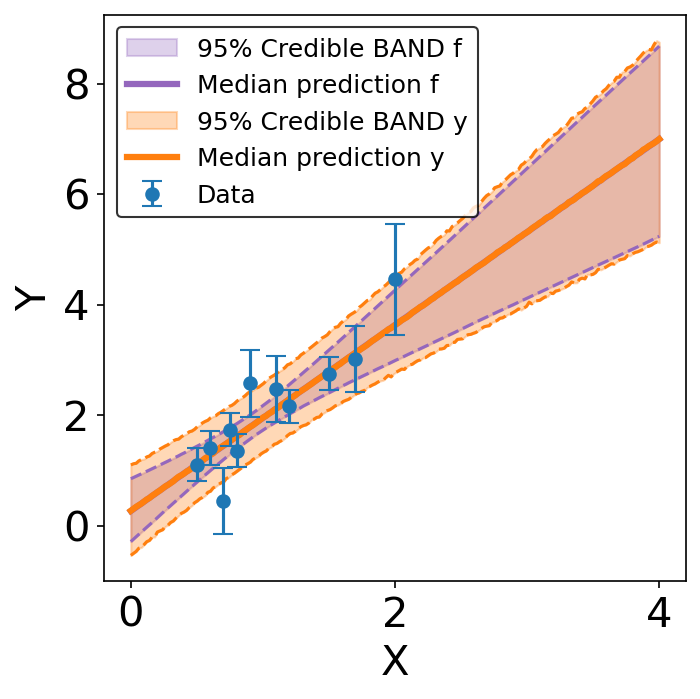

In [16]:
np.random.seed(142857)
fig, ax = plt.subplots(figsize=(5,5),dpi=150)

x_func= np.linspace(0, 4, 200)

func_rand=[model_A(x_func,alpha) for alpha in alpha_rand]

median = np.percentile(func_rand, 50, axis = 0)
upper = (np.percentile(func_rand, 97.5, axis = 0))
lower = (np.percentile(func_rand, 2.5, axis = 0))

sigma_value=0.3
y_rand=[model_A(x_func,alpha) for alpha in alpha_rand]\
+ np.random.normal(0, sigma_value, size=(len(alpha_rand), len(x_func)) )

mediany = np.percentile(y_rand, 50, axis = 0)
uppery = (np.percentile(y_rand, 97.5, axis = 0))
lowery = (np.percentile(y_rand, 2.5, axis = 0))




prediction_color_number=4


y_color_number=1


ax.fill_between(x_func, lower, upper, color=colors[prediction_color_number], alpha=0.3,label='95% Credible BAND f')

ax.plot(x_func, median, color=colors[prediction_color_number],linewidth=3,label='Median prediction f')
ax.plot(x_func, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(x_func, upper, color=colors[prediction_color_number],linestyle='dashed')

ax.fill_between(x_func, lowery, uppery, color=colors[y_color_number], alpha=0.3,label='95% Credible BAND y')

ax.plot(x_func, mediany, color=colors[y_color_number],linewidth=3,label='Median prediction y')
ax.plot(x_func, lowery, color=colors[y_color_number],linestyle='dashed')
ax.plot(x_func, uppery, color=colors[y_color_number],linestyle='dashed')


# ax.plot(x_func, true_function_A(x_func), label='True Function',color='r', alpha=0.6)

ax.errorbar(data_A_x, data_A_y, yerr=data_A_errors, fmt='o', capsize=5,label='Data')


plt.legend(fontsize=12,frameon=True, edgecolor='black')


ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
# ax.set_title('Data with Error Bars')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)



# plt.xlim(0,6)
# plt.ylim(-1,12)

plt.show()

Fantastic! Now you can tackle the other 7 problems :)